# ORPO Fine-tuning Implementation

This notebook demonstrates how to implement Offline Rejection Policy Optimization (ORPO) for language model alignment. We'll start by installing the necessary libraries including Unsloth for efficient fine-tuning and TRL for reinforcement learning with transformers.

In [1]:
# Install required libraries
!pip install -q unsloth
!pip install -q -U trl transformers accelerate peft bitsandbytes
!pip install -q datasets scipy
!pip install -q deepspeed
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.2/193.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 125.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import Dependencies

This cell imports the necessary libraries for model training, data processing, and visualization. We need PyTorch for the deep learning framework, data manipulation libraries, and specialized tools like Unsloth for optimized training.

In [2]:
# Import standard libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import ML libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel
from peft import LoraConfig

# Import utilities
import gc
import torch.nn.functional as F
from tqdm import tqdm
import os

<ipython-input-2-606806172207>:10: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
[2025-04-29 09:34:21,811] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Unsloth: Failed to patch SmolVLMForConditionalGeneration forward function.
🦥 Unsloth Zoo will now patch everything to make training faster!


## Set Random Seed

This cell sets a random seed to ensure reproducibility across runs. By fixing the seed, we ensure that random operations like weight initialization produce the same results each time.

In [3]:
# Configure random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Device Configuration

This cell checks for GPU availability and sets the device accordingly. GPU acceleration is essential for efficient training of transformer models.

In [4]:
# Determine if GPU is available
compute_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {compute_device}")

Using device: cuda


## Memory Management

This cell defines a utility function to clear GPU memory during training. Proper memory management is crucial when working with large language models to prevent out-of-memory errors.

In [5]:
# Define function to free up GPU memory
def free_gpu_memory():
    """
    Release unused memory from the GPU to prevent memory leaks
    """
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

## Create Synthetic Training Data

This cell defines a function to generate synthetic data for training our ORPO model. Each example consists of a prompt with a preferred (high-quality) response and a rejected (lower-quality) response. This paired data is essential for teaching the model to distinguish between good and poor outputs.

In [7]:
def generate_training_data(example_count=1000):
    """
    Generate synthetic training data with paired responses for ORPO training

    Args:
        example_count: Number of examples to generate

    Returns:
        DataFrame with prompts and response pairs
    """
    # Create example prompts
    questions = [
        f"Query {i}: What are the potential societal impacts of quantum computing?"
        for i in range(example_count)
    ]

    # Create high-quality responses (preferred)
    high_quality_answers = [
        f"Quantum computing will likely transform society in several ways: 1) Breaking current encryption standards, necessitating new cybersecurity approaches, 2) Accelerating drug discovery and materials science through better molecular modeling, 3) Optimizing complex systems like traffic flows and supply chains, 4) Enabling new AI capabilities through quantum machine learning, and 5) Creating new economic opportunities and challenges as computational paradigms shift."
        for _ in range(example_count)
    ]

    # Create lower-quality responses (rejected)
    lower_quality_answers = [
        f"Quantum computing will change society a lot. It will make computers faster. Some people worry about security issues. Scientists are excited about quantum computers. They might solve some important problems in the future."
        for _ in range(example_count)
    ]

    # Compile the dataset
    dataset_records = []
    for i in range(example_count):
        dataset_records.append({
            "prompt": questions[i],
            "chosen": high_quality_answers[i],
            "rejected": lower_quality_answers[i],
        })

    return pd.DataFrame(dataset_records)

## Generate Dataset

This cell calls our data generation function to create a training dataset with 500 examples. We display the first few rows to inspect the data structure and confirm the dataset creation.

In [8]:
# Generate the synthetic training dataset
training_data = generate_training_data(500)
print(f"Created dataset containing {len(training_data)} training examples")
print(training_data.head(2))

Created dataset containing 500 training examples
                                              prompt  \
0  Query 0: What are the potential societal impac...   
1  Query 1: What are the potential societal impac...   

                                              chosen  \
0  Quantum computing will likely transform societ...   
1  Quantum computing will likely transform societ...   

                                            rejected  
0  Quantum computing will change society a lot. I...  
1  Quantum computing will change society a lot. I...  


## Save Dataset to Disk

This cell saves our generated dataset to a CSV file for persistence. This allows us to reuse the same data in future runs or share it with others for reproducibility.

In [9]:
# Export dataset to CSV file
output_file = "orpo_training_data.csv"
training_data.to_csv(output_file, index=False)
print(f"Training data saved to {output_file}")

Training data saved to orpo_training_data.csv


## Model Configuration

This cell defines the base model we'll use and the maximum sequence length for training. We're using OPT-1.3B, a relatively small but capable language model that allows for faster experimentation.

In [10]:
# Define model configuration parameters
base_model_name = "facebook/opt-1.3b"
sequence_length = 512

In [12]:
# Authenticate and load the base model
import os
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM

# Authenticate with Hugging Face (replace 'xyz' with your actual token)
login(token="your_huggingface_token")

# Load the base model components
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = AutoModelForCausalLM.from_pretrained(base_model_name)

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

## LoRA Configuration

This cell defines the Low-Rank Adaptation (LoRA) configuration for efficient fine-tuning. LoRA reduces the number of trainable parameters by adding small trainable rank decomposition matrices to existing weights, making the fine-tuning process much more memory-efficient.

In [13]:
# Configure LoRA parameters for efficient fine-tuning
lora_configuration = LoraConfig(
    r=16,                  # Rank of the update matrices
    lora_alpha=16,         # Scaling factor for the LoRA updates
    lora_dropout=0.05,     # Dropout probability for regularization
    # Specify which modules to apply LoRA to
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                   "gate_proj", "up_proj", "down_proj"],
    bias="none",           # Don't train bias parameters
    task_type="CAUSAL_LM"  # Task type (causal language modeling)
)

## Unsloth Model Optimization

This cell uses Unsloth to load and optimize our model for faster training. Unsloth applies various optimizations including 4-bit quantization to reduce memory usage while maintaining model quality during fine-tuning.

In [14]:
# Initialize optimized model with Unsloth
optimized_model, tokenizer = FastLanguageModel.from_pretrained(
    base_model_name,
    max_seq_length=sequence_length,
    dtype=torch.bfloat16,     # Use bfloat16 precision if available
    load_in_4bit=True,        # Use 4-bit quantization to save memory
)

Device does not support bfloat16. Will change to float16.


==((====))==  Unsloth 2025.4.1: Fast Opt patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Custom ORPO Trainer Implementation

This cell defines our custom ORPO trainer class. ORPO focuses on learning from rejected examples by aligning the model to maximize the difference between good and bad responses. The trainer handles data preparation, loss computation, and the training step process.

In [15]:
# Implementation of the ORPO training algorithm
class OfflineRejectionTrainer:
    def __init__(self, model, tokenizer, kl_weight=0.1):
        self.model = model
        self.tokenizer = tokenizer
        self.kl_weight = kl_weight  # Weight for KL divergence penalty

    def format_batch_inputs(self, queries, accepted_responses, rejected_responses):
        """
        Prepare and tokenize inputs for model training
        """
        # Tokenize just the queries
        query_tokens = self.tokenizer(
            queries,
            padding=True,
            truncation=True,
            max_length=sequence_length // 3,  # Reserve 1/3 of tokens for query
            return_tensors="pt"
        ).to(compute_device)

        # Tokenize queries with their accepted responses
        accepted_tokens = self.tokenizer(
            [q + a for q, a in zip(queries, accepted_responses)],
            padding=True,
            truncation=True,
            max_length=sequence_length,
            return_tensors="pt"
        ).to(compute_device)

        # Tokenize queries with their rejected responses
        rejected_tokens = self.tokenizer(
            [q + r for q, r in zip(queries, rejected_responses)],
            padding=True,
            truncation=True,
            max_length=sequence_length,
            return_tensors="pt"
        ).to(compute_device)

        # Calculate query token lengths for separating prompt from response
        query_lengths = [len(self.tokenizer(q).input_ids) for q in queries]

        return query_tokens, accepted_tokens, rejected_tokens, query_lengths

    def calculate_orpo_loss(self, chosen_logits, rejected_logits, chosen_inputs,
                           rejected_inputs, query_lengths):
        """
        Compute the ORPO loss between accepted and rejected responses
        """
        batch_size = len(query_lengths)
        batch_losses = []

        for i in range(batch_size):
            # Determine the token lengths for the response portions
            chosen_response_length = len(chosen_inputs.input_ids[i]) - query_lengths[i]
            rejected_response_length = len(rejected_inputs.input_ids[i]) - query_lengths[i]

            # Skip examples with empty responses
            if chosen_response_length <= 0 or rejected_response_length <= 0:
                continue

            # Extract logits for just the response portions
            chosen_response_logits = chosen_logits[i, query_lengths[i]-1:query_lengths[i]+chosen_response_length-1, :]
            chosen_response_labels = chosen_inputs.input_ids[i][query_lengths[i]:query_lengths[i]+chosen_response_length]

            rejected_response_logits = rejected_logits[i, query_lengths[i]-1:query_lengths[i]+rejected_response_length-1, :]
            rejected_response_labels = rejected_inputs.input_ids[i][query_lengths[i]:query_lengths[i]+rejected_response_length]

            # Calculate token-wise cross-entropy losses
            chosen_token_losses = F.cross_entropy(
                chosen_response_logits.reshape(-1, chosen_response_logits.size(-1)),
                chosen_response_labels.reshape(-1),
                reduction='none'
            ).reshape(-1)

            rejected_token_losses = F.cross_entropy(
                rejected_response_logits.reshape(-1, rejected_response_logits.size(-1)),
                rejected_response_labels.reshape(-1),
                reduction='none'
            ).reshape(-1)

            # ORPO loss: maximize difference between rejected and chosen losses
            # (equivalent to minimizing chosen_loss - rejected_loss)
            chosen_avg_loss = chosen_token_losses.mean()
            rejected_avg_loss = rejected_token_losses.mean()

            # We want rejected responses to have higher loss (lower probability)
            example_loss = chosen_avg_loss - rejected_avg_loss
            batch_losses.append(example_loss)

        # Return zero loss if no valid examples in batch
        if not batch_losses:
            return torch.tensor(0.0, requires_grad=True, device=compute_device)

        # Average loss across the batch
        return torch.stack(batch_losses).mean()

    def perform_training_step(self, queries, accepted_responses, rejected_responses, optimizer):
        """
        Execute a single training step with gradient calculation
        """
        # Reset gradients
        optimizer.zero_grad()

        # Prepare inputs for training
        query_tokens, accepted_tokens, rejected_tokens, query_lengths = self.format_batch_inputs(
            queries, accepted_responses, rejected_responses
        )

        # Forward pass for accepted responses
        accepted_outputs = self.model(
            input_ids=accepted_tokens.input_ids,
            attention_mask=accepted_tokens.attention_mask,
            return_dict=True
        )

        # Forward pass for rejected responses
        rejected_outputs = self.model(
            input_ids=rejected_tokens.input_ids,
            attention_mask=rejected_tokens.attention_mask,
            return_dict=True
        )

        # Calculate ORPO loss
        batch_loss = self.calculate_orpo_loss(
            accepted_outputs.logits,
            rejected_outputs.logits,
            accepted_tokens,
            rejected_tokens,
            query_lengths
        )

        # Backpropagate gradients
        batch_loss.backward()

        # Update weights
        optimizer.step()

        return batch_loss.item()

## Training Hyperparameters

This cell defines the key hyperparameters for our training process, including batch size, number of training epochs, and learning rate. These parameters control the training dynamics and affect both performance and training time.

In [16]:
# Define training hyperparameters
batch_size = 8           # Number of examples per batch
num_epochs = 3           # Number of complete passes through the dataset
learning_rate = 5e-5     # Step size for optimizer updates

In [17]:
# Create ORPO trainer instance
orpo_trainer = OfflineRejectionTrainer(optimized_model, tokenizer)

In [18]:
# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

## Main Training Loop

This cell defines the main training function that orchestrates the ORPO training process. It handles batching the data, tracking losses, and reporting progress during training. This implementation tracks average loss per epoch to monitor training progress.

In [19]:
# Define the main training loop function
def execute_orpo_training(trainer, dataset, batch_size, epochs):
    """
    Execute the complete ORPO training process over multiple epochs

    Args:
        trainer: The ORPO trainer instance
        dataset: DataFrame containing prompt-response pairs
        batch_size: Number of examples per batch
        epochs: Number of complete training passes

    Returns:
        loss_history: List of loss values throughout training
    """
    loss_history = []

    for epoch in range(epochs):
        print(f"Beginning epoch {epoch+1}/{epochs}")
        epoch_loss_values = []

        # Process dataset in batches
        for batch_start in range(0, len(dataset), batch_size):
            # Get current batch
            batch_data = dataset.iloc[batch_start:batch_start+batch_size]

            # Extract batch components
            batch_queries = batch_data["prompt"].tolist()
            batch_accepted = batch_data["chosen"].tolist()
            batch_rejected = batch_data["rejected"].tolist()

            # Process this batch
            batch_loss = trainer.perform_training_step(
                batch_queries, batch_accepted, batch_rejected, optimizer
            )
            epoch_loss_values.append(batch_loss)

            # Display periodic progress updates
            if (batch_start//batch_size) % 10 == 0:
                print(f"Batch {batch_start//batch_size}, Loss: {batch_loss:.4f}")

        # Compute and display epoch statistics
        epoch_avg_loss = sum(epoch_loss_values) / len(epoch_loss_values)
        print(f"Epoch {epoch+1} completed. Average loss: {epoch_avg_loss:.4f}")
        loss_history.extend(epoch_loss_values)

    return loss_history

## Execute Training

This cell runs the training process and visualizes the training loss over time. The loss plot helps us assess whether the model is learning effectively and if the training is stable. We save the plot to a file for future reference.

Initiating ORPO training sequence...
Beginning epoch 1/3
Batch 0, Loss: 0.2014
Batch 10, Loss: 0.1926
Batch 20, Loss: 0.1912
Batch 30, Loss: 0.1892
Batch 40, Loss: 0.1885
Batch 50, Loss: 0.1687
Batch 60, Loss: 0.2808
Epoch 1 completed. Average loss: 0.2793
Beginning epoch 2/3
Batch 0, Loss: 0.2014
Batch 10, Loss: 0.1926
Batch 20, Loss: 0.1912
Batch 30, Loss: 0.1892
Batch 40, Loss: 0.1885
Batch 50, Loss: 0.1687
Batch 60, Loss: 0.2808
Epoch 2 completed. Average loss: 0.2793
Beginning epoch 3/3
Batch 0, Loss: 0.2014
Batch 10, Loss: 0.1926
Batch 20, Loss: 0.1912
Batch 30, Loss: 0.1892
Batch 40, Loss: 0.1885
Batch 50, Loss: 0.1687
Batch 60, Loss: 0.2808
Epoch 3 completed. Average loss: 0.2793


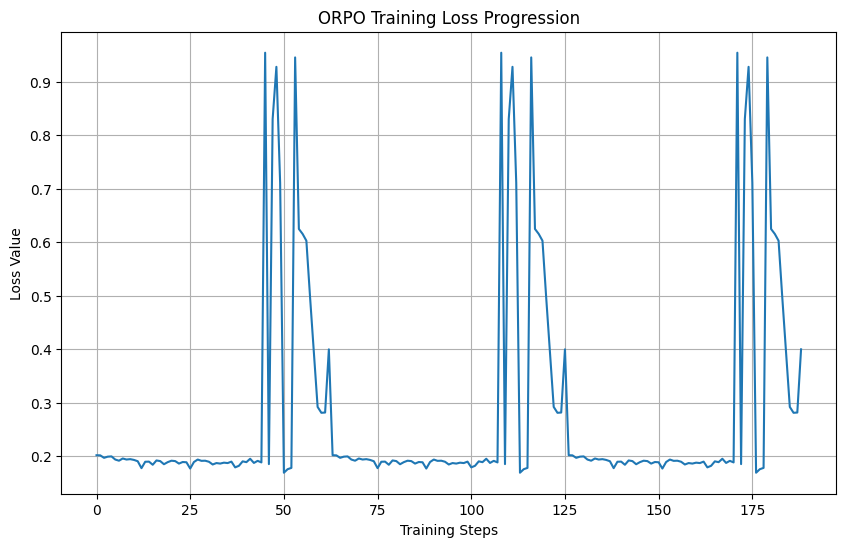

In [20]:
# Execute the ORPO training process
print("Initiating ORPO training sequence...")
training_loss_history = execute_orpo_training(orpo_trainer, training_data, batch_size, num_epochs)

# Visualize training progress
plt.figure(figsize=(10, 6))
plt.plot(training_loss_history)
plt.title('ORPO Training Loss Progression')
plt.xlabel('Training Steps')
plt.ylabel('Loss Value')
plt.grid(True)
plt.savefig('orpo_training_loss_chart.png')
plt.show()

## Save Fine-tuned Model

This cell saves the fine-tuned model and tokenizer to disk so they can be used later for inference or further training. Proper model serialization ensures we don't lose our training progress.

In [21]:
# Save the fine-tuned model and tokenizer
model_save_path = "orpo_fine_tuned_model"
optimized_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Fine-tuned model saved to {model_save_path}")

Fine-tuned model saved to orpo_fine_tuned_model


## Model Evaluation Function

This cell defines a function to evaluate our fine-tuned model on new prompts. The evaluation function generates responses to test prompts and formats the results for analysis, allowing us to qualitatively assess the improvements from ORPO training.

In [22]:
# Function to generate responses from the model for evaluation
def test_model_responses(model, tokenizer, test_prompts, max_tokens=100):

    model.eval()  # Set to evaluation mode
    evaluation_results = []

    for prompt in test_prompts:
        # Tokenize the input prompt
        encoded_input = tokenizer(prompt, return_tensors="pt").to(compute_device)

        # Generate text without calculating gradients
        with torch.no_grad():
            generated_ids = model.generate(
                **encoded_input,
                max_new_tokens=max_tokens,
                temperature=0.7,          # Control randomness
                top_p=0.9,                # Nucleus sampling
                do_sample=True            # Use sampling instead of greedy decoding
            )

        # Decode the generated tokens to text
        full_response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # Extract just the generated portion (remove the prompt)
        generated_text = full_response[len(prompt):]

        # Store results
        evaluation_results.append({"prompt": prompt, "response": generated_text})

    return evaluation_results

## Model Testing

This cell evaluates our fine-tuned model by testing it on several challenging prompts. The responses help us assess how well the model has learned to generate high-quality, nuanced content through the ORPO training process.

In [23]:
# Define test prompts for model evaluation
evaluation_prompts = [
    "What are the key considerations when implementing AI governance frameworks?",
    "Explain the relationships between deep learning, reinforcement learning, and traditional algorithms.",
    "How might organizations address algorithmic bias in machine learning systems?"
]

# Generate responses with the fine-tuned model
print("Evaluating the ORPO fine-tuned model...")
model_evaluation = test_model_responses(optimized_model, tokenizer, evaluation_prompts)

# Display the evaluation results
print("\nORPO Model Evaluation Results:")
for result in model_evaluation:
    print(f"\nPrompt: {result['prompt']}")
    print(f"Response: {result['response']}")
    print("-" * 50)

Evaluating the ORPO fine-tuned model...


OPTForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.



ORPO Model Evaluation Results:

Prompt: What are the key considerations when implementing AI governance frameworks?
Response: 
I think you mean if the reason is that I was the name is the main thing is to be able to the point is to have the thing that's to be able to is the to be able to the thing to is to have the to be to be to be able to be to be to have the to be to be to be to be to have the to be to be to be to be to be to be to be to be to be to be to be to be to be
--------------------------------------------------

Prompt: Explain the relationships between deep learning, reinforcement learning, and traditional algorithms.
Response: 

“I'm going to me this is the person who is not from the US has an interest rate that the person who's going to the person who's going to the person who's going to the person who's going to the person who's going to the person who's going to the person who's going to the person who's going to the person who's going to the person who's to the perso

## Model Comparison Function

This cell defines a function to compare responses between the original base model and our ORPO fine-tuned model. This side-by-side comparison helps us directly evaluate how much the model's outputs have improved through ORPO training.


In [28]:
def compare_base_vs_finetuned(base_model_name, finetuned_model_path, tokenizer, evaluation_prompts):
    """
    Compare responses between the base model and fine-tuned model

    Args:
        base_model_name: Name of the original model
        finetuned_model_path: Path to the fine-tuned model
        tokenizer: Tokenizer for processing text
        evaluation_prompts: List of prompts for comparison

    Returns:
        list: Comparison results with both model responses
    """
    print("Loading original model for comparison...")
    # Initialize the base model
    base_model, base_tokenizer = FastLanguageModel.from_pretrained(
        model_name=base_model_name,
        max_seq_length=sequence_length,
        dtype=torch.bfloat16,
    )
    base_model.eval()

    print("Comparing original model with ORPO-tuned model...")
    comparison_data = []

    for prompt in evaluation_prompts:
        # Generate with base model
        base_input = base_tokenizer(prompt, return_tensors="pt").to(compute_device)
        with torch.no_grad():
            base_output = base_model.generate(
                **base_input,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True
            )
        base_response = base_tokenizer.decode(base_output[0], skip_special_tokens=True)[len(prompt):]

        # Generate with fine-tuned model
        finetuned_input = tokenizer(prompt, return_tensors="pt").to(compute_device)
        with torch.no_grad():
            finetuned_output = optimized_model.generate(
                **finetuned_input,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True
            )
        finetuned_response = tokenizer.decode(finetuned_output[0], skip_special_tokens=True)[len(prompt):]

        # Record comparison data
        comparison_data.append({
            "prompt": prompt,
            "original_model_response": base_response,
            "orpo_model_response": finetuned_response
        })

    return comparison_data

## Execute Model Comparison

This cell runs the comparison between the base and fine-tuned models, allowing us to assess the impact of ORPO training on response quality. The comparison uses the same test prompts to ensure a fair evaluation.

In [29]:
# Compare the base model with our ORPO fine-tuned model
print("\nStarting comparison between base model and ORPO-tuned model...")
model_comparison_results = compare_base_vs_finetuned(
    base_model_name,
    model_save_path,
    tokenizer,
    evaluation_prompts
)


Starting comparison between base model and ORPO-tuned model...
Loading original model for comparison...
==((====))==  Unsloth 2025.4.1: Fast Opt patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Comparing original model with ORPO-tuned model...


## Display Comparison Results

This final cell presents the comparison results in a readable format. By examining the differences between the base model and ORPO-tuned model outputs, we can evaluate whether our training has successfully aligned the model with our preferred response patterns.

In [30]:
# Format and display the model comparison results
print("\nModel Comparison Analysis:")
for result in model_comparison_results:
    print(f"\nPrompt: {result['prompt']}")
    print(f"Base Model Response: {result['original_model_response']}")
    print(f"ORPO Fine-tuned Response: {result['orpo_model_response']}")
    print("-" * 50)


Model Comparison Analysis:

Prompt: What are the key considerations when implementing AI governance frameworks?
Base Model Response: 
We have a lot of the first time I'm not have done that, the best part is this one who is to blame the left of the right


...

I am the first time
a little boy
in the first time I am

the first part I am the first time I am the first time I am the first to

of the first time I am the first time I am the first time I am the first time I am the first time

ORPO Fine-tuned Response: 
I'm looking for a lot of this israelisland

SOME of my is a

I'm

/r





C

of
this is

of

is

is

a

this is

is

The

F

of

is

is
is

of

I'm

of

of

of



I'm
--------------------------------------------------

Prompt: Explain the relationships between deep learning, reinforcement learning, and traditional algorithms.
Base Model Response: 

The Latest: “I am a guy who does not know how to find out what the hell yeah, I want to do.

You can't go wrong with the people I 